In [25]:
import torch
import torch.optim as optim
import numpy as np
from PIL import Image, ImageDraw
from torchvision import models, transforms
import requests
import matplotlib.pyplot as plt

# Load ImageNet class index
URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
class_idx = requests.get(URL).json()


In [48]:
def get_class_label(idx):
    return class_idx[str(idx)][1]

def load_pretrained_model():
    model = models.vgg19(pretrained=True)
    model.eval()
    return model

def adversarial_loss(output, target):
    target_log_prob = torch.nn.functional.log_softmax(output, dim=1)[0, target]
    return -target_log_prob  # Maximize this log probability

def draw_complex_mask(center, rays, angles, image_size):
    image = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(image)
    for angle, ray in zip(angles, rays):
        end_x = int(center[0] + ray * np.cos(angle))
        end_y = int(center[1] + ray * np.sin(angle))
        draw.polygon([center, (end_x, end_y), (center[0], center[1] + ray)], fill=int(np.random.rand() * 255))
    return np.array(image)

In [51]:
def generate_adversarial_patch(initial_shape, target_class, iterations=500):
    center = (250, 250)
    image_size = (500, 500)
    angles = np.linspace(0, 2 * np.pi, len(initial_shape), endpoint=False)
    rays = np.random.uniform(50, 150, len(initial_shape))
    texture = torch.rand(3, *image_size, requires_grad=True)
    optimizer = optim.Adam([texture], lr=0.01)

    for i in range(iterations):
        optimizer.zero_grad()
        output = mock_classifier(texture)
        loss = adversarial_loss(output, target_class)
        (-loss).backward()  # Negate loss for gradient ascent
        optimizer.step()

    mask = draw_mask(center, rays, angles, image_size)
    mask_tensor = torch.from_numpy(mask).to(torch.float32).unsqueeze(0) / 255.0
    patch_array = texture.detach() * mask_tensor
    patch_array = patch_array.permute(1, 2, 0).numpy()
    return patch_array


In [52]:
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((500, 500)),
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)

# Example usage with mock data
model = models.vgg19(pretrained=True)
model.eval()
image_path = "aero.jpg"  # Change to your image path
input_image = load_image(image_path)
original_output = model(input_image)
original_class = original_output.argmax().item()
original_label = get_class_label(original_class)

In [53]:
# Adversarial attack setup
target_class = 1  # Change to desired target class
print(get_class_label(target_class))
patch = generate_adversarial_patch([100]*20, target_class)  # Example shape
patch_tensor = torch.tensor(patch, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
patched_image = input_image + patch_tensor
patched_image = torch.clamp(patched_image, 0, 1)

patched_output = model(patched_image)
patched_class = patched_output.argmax().item()
patched_label = get_class_label(patched_class)

goldfish


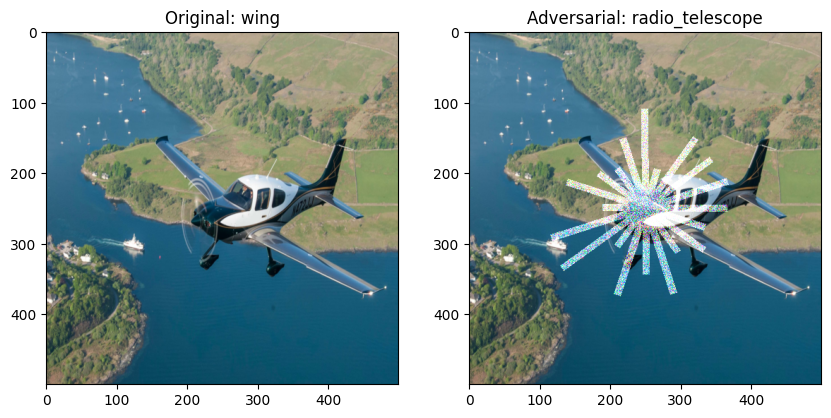

In [54]:
#Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(transforms.ToPILImage()(input_image.squeeze(0)))
plt.title(f"Original: {original_label}")
plt.subplot(1, 2, 2)
plt.imshow(transforms.ToPILImage()(patched_image.squeeze(0)))
plt.title(f"Adversarial: {patched_label}")
plt.show()